**Project 2 - Noise Removal**

*ECE574/692 - Computer Vision, Spring 2025*

In [ ]:
# Convert NP to TORCH for efficient training
# Try optimized bilat and NLM

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import random
import bm3d

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Define Denoising Autoencoder (DAE)
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 14x14 -> 7x7
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 6, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(6, 1, kernel_size=2, stride=2),   # 14x14 -> 28x28
            nn.Sigmoid()  # Normalize output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
# Function to add Gaussian noise
def add_noise(img, noise_factor=0.5):
    noisy_img = img + noise_factor * torch.randn_like(img)
    return torch.clamp(noisy_img, 0., 1.)

In [17]:
def add_salt_pepper_noise(img, noise_factor=0.05):
    """
    Adds salt and pepper noise to the input image.
    
    Parameters:
        img (torch.Tensor): Input image tensor with values in [0,1].
        noise_factor (float): Proportion of pixels to alter (default=0.05).
                              This represents the overall noise level.
    
    Returns:
        torch.Tensor: Noisy image with salt and pepper noise.
    """
    noisy_img = img.clone()
    # Generate a tensor of random values in [0,1] with the same shape as the image.
    rnd = torch.rand_like(noisy_img)
    
    # Set some pixels to 0 (pepper) and some to 1 (salt).
    # For pepper noise, pixels with random values less than half the noise factor become 0.
    noisy_img[rnd < noise_factor / 2] = 0.0
    
    # For salt noise, pixels with random values greater than 1 minus half the noise factor become 1.
    noisy_img[rnd > 1 - (noise_factor / 2)] = 1.0
    
    return noisy_img

In [18]:
# Visualize results
def show_images(original, noisy, denoised):
    fig, axes = plt.subplots(3, 10, figsize=(10, 3))
    for i in range(10):
        axes[0, i].imshow(original[i].squeeze(), cmap="gray")
        axes[1, i].imshow(noisy[i].squeeze(), cmap="gray")
        axes[2, i].imshow(denoised[i].squeeze(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].axis("off")
        axes[2, i].axis("off")
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Noisy")
    axes[2, 0].set_ylabel("Denoised")
    plt.show()

Epoch [1/5], Loss: 0.0267
Epoch [2/5], Loss: 0.0186
Epoch [3/5], Loss: 0.0184
Epoch [4/5], Loss: 0.0174
Epoch [5/5], Loss: 0.0161


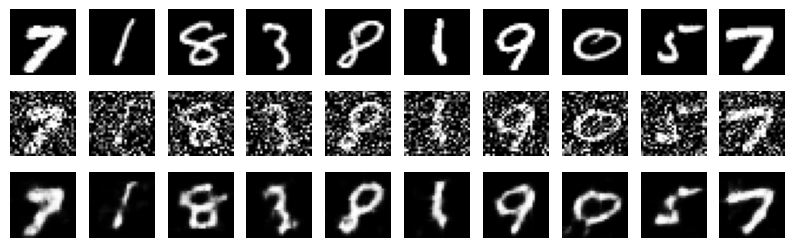

In [20]:
# Load MNIST dataset with noise addition
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize model, loss function, and optimizer
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs).to(device)  # Add noise
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs)  # Compare with clean images
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Test the model
test_imgs, _ = next(iter(train_loader))
test_noisy = add_noise(test_imgs)
test_imgs, test_noisy = test_imgs.to(device), test_noisy.to(device)

with torch.no_grad():
    denoised_imgs = model(test_noisy)

# Convert to NumPy for visualization
show_images(test_imgs.cpu(), test_noisy.cpu(), denoised_imgs.cpu())

In [21]:
# -----------------------------
# BM3D Denoising
# -----------------------------

def bm3d_denoise(image_np, sigma=0.1):
    """
    Apply BM3D denoising on a 2D numpy array image.
    
    Parameters:
        image_np (numpy.ndarray): 2D image array with values in [0,1].
        sigma (float): Estimated noise standard deviation. Higher values lead to stronger denoising.
        
    Returns:
        denoised (numpy.ndarray): Denoised 2D image.
    """
    # Ensure the image values are within the [0,1] range
    image_np = np.clip(image_np, 0, 1)
    
    # Apply BM3D denoising; bm3d.bm3d expects sigma in the same scale as the image.
    denoised = bm3d.bm3d(image_np, sigma_psd=sigma)
    
    # Clamp the output image to ensure values are within [0,1]
    return np.clip(denoised, 0, 1)

In [32]:
# -----------------------------
# Non-local Means Denoising Implementation
# -----------------------------
def non_local_means_denoise(image_np, patch_size=3, search_window=7, h=0.1):
    """
    Apply non-local means denoising on a 2D numpy array image.
    
    Parameters:
        image_np (numpy.ndarray): 2D image array with values in [0,1].
        patch_size (int): Size of the patch (odd number).
        search_window (int): Size of the search window (odd number).
        h (float): Filtering parameter controlling decay of the exponential.
        
    Returns:
        denoised (numpy.ndarray): Denoised 2D image.
    """

    # Ensure patch_size and search_window are odd
    # This will be added to the image to allow the patch to go through the image and be 
    # centered on each individual pixel
    pad_patch = patch_size // 2
    
    # Used to allow a search window centered on each pixel
    pad_search = search_window // 2
    
    # Pad image to handle borders
    # reflects image values into the padded areas
    padded = np.pad(image_np, pad_patch + pad_search, mode='reflect')
    h2 = h * h
    H, W = image_np.shape
    denoised = np.zeros_like(image_np)
    
    # Loop over each pixel in the original image
    for i in range(H):
        for j in range(W):
            i_p = i + pad_patch + pad_search
            j_p = j + pad_patch + pad_search
            
            # Extract central patch
            patch = padded[i_p-pad_patch:i_p+pad_patch+1, j_p-pad_patch:j_p+pad_patch+1]
            weight_sum = 0.0
            pixel_val = 0.0
            
            # Loop over the search window
            # The nested loops over k and l cover all neighboring pixels within 
            # the search_window centered at the current pixel.
            for k in range(i_p - pad_search, i_p + pad_search + 1):
                for l in range(j_p - pad_search, j_p + pad_search + 1):
                    
                    # patch to compare to the current pixel patch
                    neighbor_patch = padded[k-pad_patch:k+pad_patch+1, l-pad_patch:l+pad_patch+1]
                    
                    # Compute squared Euclidean distance between different patches
                    d2 = np.sum((patch - neighbor_patch)**2)
                    
                    # Compute weight as exponential of negative distance
                    # This means similar patches (with low d2) contribute more heavily to the denoised value, 
                    # while dissimilar patches contribute very little.
                    weight = np.exp(-d2 / h2)
                    weight_sum += weight
                    pixel_val += weight * padded[k, l]
            
            # Normalize the denoised pixel value by the sum of weights
            # If weight_sum is zero, we keep the original pixel value
            # pixel_val is the sum of all the contributions from neighboring pixels
            # weight_sum is the sum of all the weights
            denoised[i, j] = pixel_val / weight_sum if weight_sum != 0 else image_np[i, j]
    return denoised

In [33]:
### NLM Denoising ChatGPT optimization
def non_local_means_denoise_optim(image_np, patch_size=3, search_window=7, h=0.1):
    """
    Apply non-local means denoising on a 2D numpy array image.
    
    Parameters:
        image_np (numpy.ndarray): 2D image array with values in [0,1].
        patch_size (int): Size of the patch (odd number).
        search_window (int): Size of the search window (odd number).
        h (float): Filtering parameter controlling decay of the exponential.
        
    Returns:
        denoised (numpy.ndarray): Denoised 2D image.
    """

    # Ensure patch_size and search_window are odd
    pad_patch = patch_size // 2
    pad_search = search_window // 2
    
    # Pad image to handle borders (same as before)
    padded = np.pad(image_np, pad_patch + pad_search, mode='reflect')
    h2 = h * h
    H, W = image_np.shape
    denoised = np.zeros_like(image_np)
    
    # Loop over each pixel in the original image (outer loops remain)
    for i in range(H):
        for j in range(W):
            i_p = i + pad_patch + pad_search
            j_p = j + pad_patch + pad_search
            
            # Extract central patch (unchanged)
            patch = padded[i_p-pad_patch:i_p+pad_patch+1, j_p-pad_patch:j_p+pad_patch+1]
            
            # --- Changed: Replace inner two loops with vectorized extraction ---
            # Extract a region from the padded image that is large enough to contain all neighbor patches
            region = padded[i_p - pad_search - pad_patch : i_p + pad_search + pad_patch + 1,
                            j_p - pad_search - pad_patch : j_p + pad_search + pad_patch + 1]
            # Use sliding_window_view to extract all neighbor patches at once.
            # This returns an array of shape (2*pad_search+1, 2*pad_search+1, patch_size, patch_size)
            neighbor_patches = np.lib.stride_tricks.sliding_window_view(region, (patch_size, patch_size))
            # Compute squared differences between the central patch and all neighbor patches simultaneously.
            diff = neighbor_patches - patch  # broadcast subtraction
            d2 = np.sum(diff**2, axis=(-1, -2))  # shape: (2*pad_search+1, 2*pad_search+1)
            # Compute weights based on the squared differences.
            weights = np.exp(-d2 / h2)
            weight_sum = np.sum(weights)
            # Get the center pixel from each neighbor patch.
            neighbor_pixels = neighbor_patches[:, :, pad_patch, pad_patch]
            pixel_val = np.sum(weights * neighbor_pixels)
            # --------------------------------------------------------------------
            
            # Normalize the denoised pixel value by the sum of weights.
            denoised[i, j] = pixel_val / weight_sum if weight_sum != 0 else image_np[i, j]
    return denoised

In [34]:
# -----------------------------
# Bilateral Filtering Denoising Implementation
# -----------------------------
def bilateral_filter(image_np, kernel_size = 5, spatial_sigma=1.0, intensity_sigma=0.1):
    """
    Apply bilateral filtering on a 2D numpy array image.
    
    Parameters:
        image_np (numpy.ndarray): 2D image array with values in [0,1].
        kernel_size (int): Size of the bilateral filter kernel (odd number).
        spatial_sigma (float): Standard deviation for the spatial Gaussian. Controls weight based on Euclidean distance.
            A smaller value means that only pixels close to the center pixel will contribute to the denoised value.
        intensity_sigma (float): Standard deviation for the range Gaussian. Controls weight based on intensity difference. A
            smaller value means that only pixels with very similar intensities will contribute to the denoised value.
        
    Returns:
        filtered (numpy.ndarray): Denoised 2D image.
    """
    pad = kernel_size // 2
    padded = np.pad(image_np, pad, mode='reflect')
    H, W = image_np.shape
    
    # Initialize filtered image
    filtered = np.zeros_like(image_np)
    
    # Precompute spatial Gaussian weights
    x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
    x = x - pad
    y = y - pad
    
    # Compute spatial Gaussian weights
    spatial_weight = np.exp(-(x**2 + y**2) / (2 * spatial_sigma**2))
    
    for i in range(H):
        for j in range(W):
            i_p = i + pad
            j_p = j + pad
            center_val = padded[i_p, j_p]
            
            # Extract local window from padded image
            window = padded[i_p - pad:i_p + pad + 1, j_p - pad:j_p + pad + 1]
            
            # Compute range Gaussian weights based on intensity differences
            intensity_weight = np.exp(-((window - center_val)**2) / (2 * intensity_sigma**2))
            
            # Combined bilateral weight
            weights = spatial_weight * intensity_weight
            
            
            weight_sum = np.sum(weights)
            
            # Normalize and compute filtered value
            filtered[i, j] = np.sum(window * weights) / weight_sum
    return filtered

In [35]:
### Bilateral Filtering ChatGPT optimization
def bilateral_filter_optim(image_np, kernel_size = 5, spatial_sigma=1.0, intensity_sigma=0.1):
    """
    Apply bilateral filtering on a 2D numpy array image.
    
    Parameters:
        image_np (numpy.ndarray): 2D image array with values in [0,1].
        kernel_size (int): Size of the bilateral filter kernel (odd number).
        spatial_sigma (float): Standard deviation for the spatial Gaussian. Controls weight based on Euclidean distance.
            A smaller value means that only pixels close to the center pixel will contribute to the denoised value.
        intensity_sigma (float): Standard deviation for the range Gaussian. Controls weight based on intensity difference. A
            smaller value means that only pixels with very similar intensities will contribute to the denoised value.
        
    Returns:
        filtered (numpy.ndarray): Denoised 2D image.
    """
    pad = kernel_size // 2
    padded = np.pad(image_np, pad, mode='reflect')
    H, W = image_np.shape

    # Precompute spatial Gaussian weights (unchanged)
    x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
    x = x - pad
    y = y - pad
    spatial_weight = np.exp(-(x**2 + y**2) / (2 * spatial_sigma**2))
    
    # CHANGE: Instead of looping over each pixel, extract all local windows at once using sliding_window_view.
    # This creates an array of shape (H, W, kernel_size, kernel_size).
    windows = np.lib.stride_tricks.sliding_window_view(padded, (kernel_size, kernel_size))
    
    # CHANGE: Extract the center value of each patch (located at index [pad, pad] in the patch).
    center_vals = windows[:, :, pad, pad]
    
    # CHANGE: Compute the range weights for all patches at once. We subtract the center value (expanded to match patch dimensions)
    # from each patch, then compute the Gaussian based on the intensity difference.
    intensity_weight = np.exp(-((windows - center_vals[:, :, None, None])**2) / (2 * intensity_sigma**2))
    
    # CHANGE: Multiply the spatial weight (broadcasted to each window) with the intensity weight.
    combined_weights = spatial_weight[None, None, :, :] * intensity_weight
    
    # Compute the weighted sum and the sum of weights for each pixel.
    weight_sum = np.sum(combined_weights, axis=(-1, -2))
    weighted_sum = np.sum(windows * combined_weights, axis=(-1, -2))
    
    # Compute the filtered image.
    filtered = weighted_sum / weight_sum
    return filtered

In [36]:
def calculate_psnr(original, denoised):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original and denoised images.
    
    Parameters:
        original (numpy.ndarray): Original 2D image array with values in [0,1].
        denoised (numpy.ndarray): Denoised 2D image array with values in [0,1].
        
    Returns:
        psnr (float): PSNR value in decibels (dB). A higher value indicates better image quality.
    """
    # Compute the Mean Squared Error (MSE) between the images.
    mse = np.mean((original - denoised) ** 2)
    
    # If MSE is zero, return infinity (perfect match)
    if mse == 0:
        return float('inf')
    
    # Maximum pixel value for images in [0,1] is 1.
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

In [ ]:
# Figures showing noisying and denoising on the angio.pgm image and noise vs PSNR for different models
# -----------------------------
# Parameters (easily changeable)
# -----------------------------

# Gaussian noise parameters (σ values in the image domain: for add_noise, we convert to a noise_factor)
gaussian_sigmas = [1, 5, 10, 15, 20]

# Conversion: since images are in [0,1], we assume σ_image = sigma/255.
def sigma_to_noise_factor(sigma):
    return sigma / 255.0

# Salt & Pepper noise percentages (in %; note: noise_factor in add_salt_pepper_noise is the proportion of pixels altered)
snp_percentages = [1, 3, 5, 7, 9]  # in percent

# Denoising parameters:
bilateral_params = {"kernel_size": 5, "spatial_sigma": 1.0, "intensity_sigma": 0.1}
non_local_params = {"patch_size": 3, "search_window": 7, "h": 0.1}
bm3d_params = {"sigma": 0.1}  # Note: bm3d expects sigma in the same scale as the image (i.e., [0,1])

# -----------------------------
# Get one sample image from the MNIST training dataset
# -----------------------------
# sample_img, label = train_dataset[0]  # sample_img is a torch.Tensor with shape (1,28,28)
# original_img = sample_img.squeeze().numpy()  # convert to 2D numpy array

# -----------------------------
# NEW: Load the "image.pgm" file for testing
# -----------------------------
original_img = plt.imread("angio.pgm")  # load the pgm image (assumed to be grayscale with values in [0,1])
if original_img.ndim == 3:
    original_img = original_img[..., 0]  # if the image has multiple channels, take the first one

# CHANGE: Check if the image is in the [0,1] range. If not, normalize it.
if original_img.max() > 1:
    original_img = original_img / 255.0  # Normalize assuming original image is in 0-255 range

sample_img = torch.from_numpy(original_img).unsqueeze(0).float()  # convert to torch.Tensor with shape (1,H,W)

# -----------------------------
# Figure 1: PSNR vs. Gaussian noise level for 3 methods
# -----------------------------
psnr_bilateral_gauss = []
psnr_nonlocal_gauss = []
psnr_bm3d_gauss = []

for sigma in gaussian_sigmas:
    # Convert sigma to noise_factor for add_noise
    noise_factor = sigma_to_noise_factor(sigma)
    # Add Gaussian noise using torch (output is a tensor)
    noisy_tensor = add_noise(sample_img, noise_factor=noise_factor)
    # Convert noisy image to numpy 2D array
    noisy_img = noisy_tensor.squeeze().numpy()
    
    # Denoise using bilateral filter
    denoised_bilateral = bilateral_filter(noisy_img, **bilateral_params)
    psnr_bilateral_gauss.append(calculate_psnr(original_img, denoised_bilateral))
    
    # Denoise using non-local means
    denoised_nonlocal = non_local_means_denoise(noisy_img, **non_local_params)
    psnr_nonlocal_gauss.append(calculate_psnr(original_img, denoised_nonlocal))
    
    # Denoise using BM3D
    denoised_bm3d = bm3d_denoise(noisy_img, sigma=bm3d_params["sigma"])
    psnr_bm3d_gauss.append(calculate_psnr(original_img, denoised_bm3d))

plt.figure(figsize=(8,6))
plt.plot(gaussian_sigmas, psnr_bilateral_gauss, 'o-', label=f'Bilateral\n{bilateral_params}')
plt.plot(gaussian_sigmas, psnr_nonlocal_gauss, 's-', label=f'Non-local Means\n{non_local_params}')
plt.plot(gaussian_sigmas, psnr_bm3d_gauss, 'd-', label=f'BM3D\n{bm3d_params}')
plt.xlabel("Gaussian Noise σ")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Gaussian Noise Level\n(noise_factor = σ/255)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# -----------------------------
# Figure 2: PSNR vs. Salt & Pepper noise level for 3 methods
# -----------------------------
psnr_bilateral_snp = []
psnr_nonlocal_snp = []
psnr_bm3d_snp = []

for perc in snp_percentages:
    # Convert percentage to noise_factor (proportion)
    noise_factor = perc / 100.0
    # Add salt and pepper noise using torch
    noisy_tensor = add_salt_pepper_noise(sample_img, noise_factor=noise_factor)
    noisy_img = noisy_tensor.squeeze().numpy()
    
    # Denoise using bilateral filter
    denoised_bilateral = bilateral_filter(noisy_img, **bilateral_params)
    psnr_bilateral_snp.append(calculate_psnr(original_img, denoised_bilateral))
    
    # Denoise using non-local means
    denoised_nonlocal = non_local_means_denoise(noisy_img, **non_local_params)
    psnr_nonlocal_snp.append(calculate_psnr(original_img, denoised_nonlocal))
    
    # Denoise using BM3D
    denoised_bm3d = bm3d_denoise(noisy_img, sigma=bm3d_params["sigma"])
    psnr_bm3d_snp.append(calculate_psnr(original_img, denoised_bm3d))

plt.figure(figsize=(8,6))
plt.plot(snp_percentages, psnr_bilateral_snp, 'o-', label=f'Bilateral\n{bilateral_params}')
plt.plot(snp_percentages, psnr_nonlocal_snp, 's-', label=f'Non-local Means\n{non_local_params}')
plt.plot(snp_percentages, psnr_bm3d_snp, 'd-', label=f'BM3D\n{bm3d_params}')
plt.xlabel("Salt & Pepper Noise (%)")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Salt & Pepper Noise Level")
plt.legend()
plt.grid(True)
plt.tight_layout()

# -----------------------------
# Figure 3: Example with Gaussian noise (5 subplots)
# -----------------------------
# Choose a specific Gaussian noise level to visualize (e.g., σ=10)
example_sigma = 20
example_noise_factor = sigma_to_noise_factor(example_sigma)
example_noisy_tensor = add_noise(sample_img, noise_factor=example_noise_factor)
example_noisy_img = example_noisy_tensor.squeeze().numpy()

# Denoise with each method
example_denoised_bilateral = bilateral_filter(example_noisy_img, **bilateral_params)
example_denoised_nonlocal = non_local_means_denoise(example_noisy_img, **non_local_params)
example_denoised_bm3d = bm3d_denoise(example_noisy_img, sigma=bm3d_params["sigma"])

plt.figure(figsize=(15,5))
plt.subplot(1,5,1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(example_noisy_img, cmap='gray')
plt.title(f"Gaussian Noise\nσ={example_sigma} (noise_factor={example_noise_factor:.3f})")
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(example_denoised_bilateral, cmap='gray')
plt.title(f"Bilateral Filter\n{bilateral_params}")
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(example_denoised_nonlocal, cmap='gray')
plt.title(f"Non-local Means\n{non_local_params}")
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(example_denoised_bm3d, cmap='gray')
plt.title(f"BM3D\n{bm3d_params}")
plt.axis('off')
plt.suptitle("Gaussian Noise Denoising Example", fontsize=16)

# Adjust layout so the suptitle does not overlap the subplots
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.subplots_adjust(top=0.75)  # added to prevent title overlap


# -----------------------------
# Figure 4: Example with Salt & Pepper noise (5 subplots)
# -----------------------------
# Choose a specific salt & pepper noise level to visualize (e.g., 5%)
example_snp_percentage = 10
example_snp_noise_factor = example_snp_percentage / 100.0
example_snp_noisy_tensor = add_salt_pepper_noise(sample_img, noise_factor=example_snp_noise_factor)
example_snp_noisy_img = example_snp_noisy_tensor.squeeze().numpy()

# Denoise with each method
example_snp_denoised_bilateral = bilateral_filter(example_snp_noisy_img, **bilateral_params)
example_snp_denoised_nonlocal = non_local_means_denoise(example_snp_noisy_img, **non_local_params)
example_snp_denoised_bm3d = bm3d_denoise(example_snp_noisy_img, sigma=bm3d_params["sigma"])

plt.figure(figsize=(15,5))
plt.subplot(1,5,1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(example_snp_noisy_img, cmap='gray')
plt.title(f"Salt & Pepper Noise\n{example_snp_percentage}% (noise_factor={example_snp_noise_factor:.2f})")
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(example_snp_denoised_bilateral, cmap='gray')
plt.title(f"Bilateral Filter\n{bilateral_params}")
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(example_snp_denoised_nonlocal, cmap='gray')
plt.title(f"Non-local Means\n{non_local_params}")
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(example_snp_denoised_bm3d, cmap='gray')
plt.title(f"BM3D\n{bm3d_params}")
plt.axis('off')
plt.suptitle("Salt & Pepper Noise Denoising Example", fontsize=16)

# Adjust layout so the suptitle does not overlap the subplots
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.subplots_adjust(top=0.75)  # added to prevent title overlap


plt.show()

In [24]:
# New visualization function to display 4 rows (Original, Noisy, Non-local Means, Bilateral)
def show_images_with_bilateral(original, noisy, denoised_nlm, denoised_bilateral):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4))
    for i in range(10):
        axes[0, i].imshow(original[i].squeeze(), cmap="gray")
        axes[1, i].imshow(noisy[i].squeeze(), cmap="gray")
        axes[2, i].imshow(denoised_nlm[i].squeeze(), cmap="gray")
        axes[3, i].imshow(denoised_bilateral[i].squeeze(), cmap="gray")
        for r in range(4):
            axes[r, i].axis("off")
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Noisy")
    axes[2, 0].set_ylabel("NLM")
    axes[3, 0].set_ylabel("Bilateral")
    plt.show()

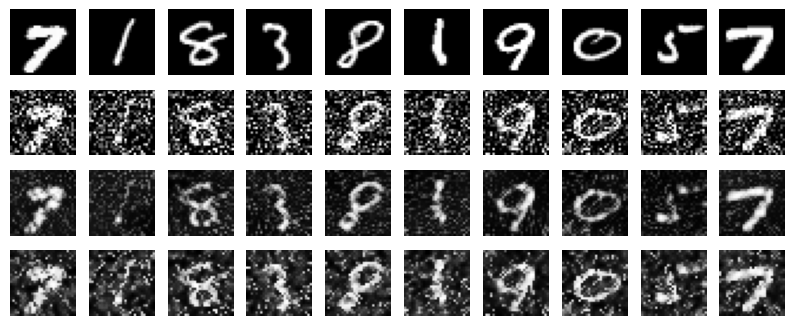

In [25]:
patch_size = 3
search_window = 29
h = 0.8

# -----------------------------
# Apply non-local means denoising and bilateral filtering, then display results
# -----------------------------
# Convert the test noisy images to NumPy and apply non-local means on the first 10 images
non_local_denoised = []
test_noisy_np = test_noisy.cpu().numpy()  # shape: (batch_size, 1, 28, 28)
for i in range(10):
    # Extract the 2D image from channel dimension
    image_np = test_noisy_np[i, 0, :, :]
    denoised_np = non_local_means_denoise(image_np, patch_size = patch_size, search_window = search_window, h = h)
    non_local_denoised.append(denoised_np)
non_local_denoised = np.array(non_local_denoised)
# Convert back to a tensor and add channel dimension
non_local_denoised_tensor = torch.from_numpy(non_local_denoised).unsqueeze(1)


kernel_size = 3
spatial_sigma = 1.5
intensity_sigma = 0.4

# Apply bilateral filtering on the first 10 noisy images
bilateral_denoised = []
for i in range(10):
    image_np = test_noisy_np[i, 0, :, :]
    filtered_np = bilateral_filter(image_np, kernel_size = kernel_size, spatial_sigma = spatial_sigma, intensity_sigma = intensity_sigma)
    bilateral_denoised.append(filtered_np)
bilateral_denoised = np.array(bilateral_denoised)
bilateral_denoised_tensor = torch.from_numpy(bilateral_denoised).unsqueeze(1)

# Display the results with the same visualization as before - NLM algo only
#show_images(test_imgs.cpu(), test_noisy.cpu(), non_local_denoised_tensor.cpu())

# Display the results with the new 4-row visualization
show_images_with_bilateral(test_imgs.cpu(), test_noisy.cpu(), non_local_denoised_tensor.cpu(), bilateral_denoised_tensor.cpu())



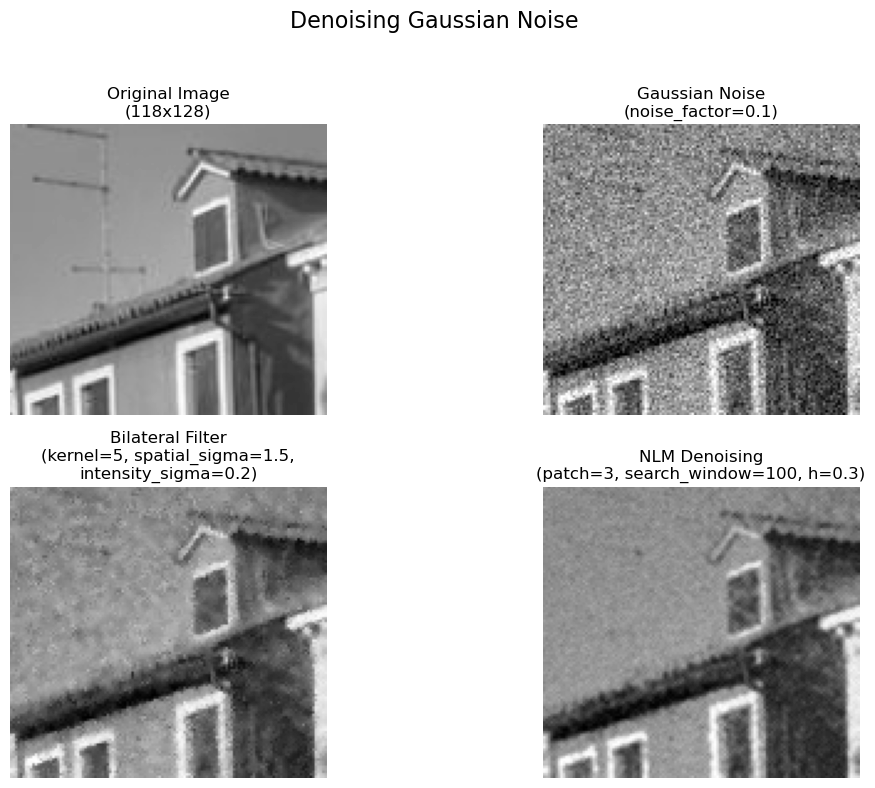

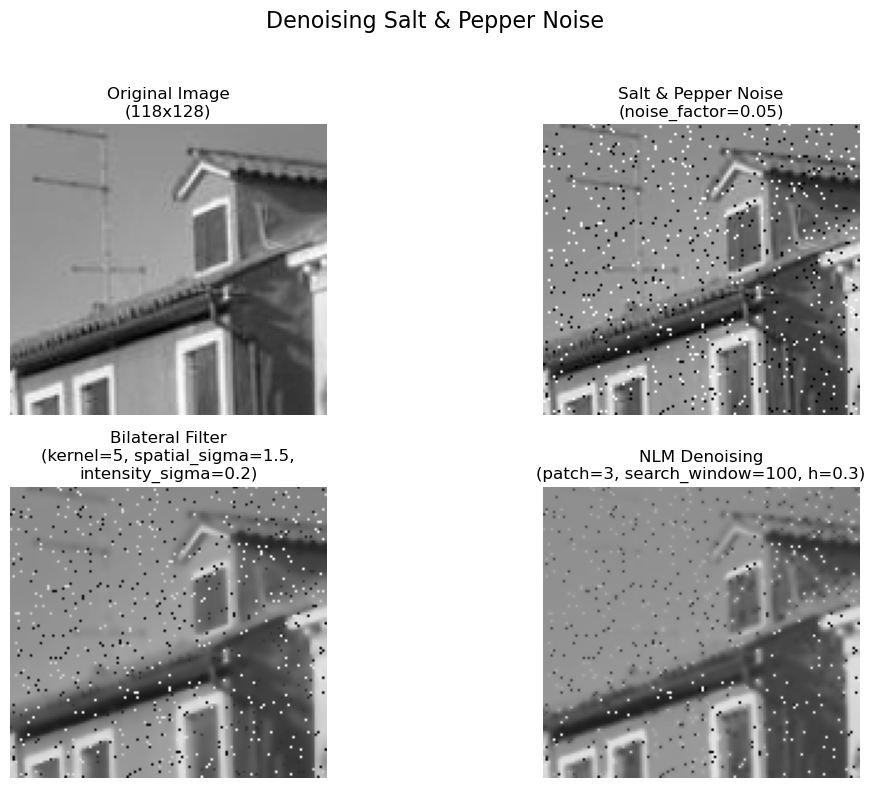

In [12]:
from PIL import Image

# =============================
# New code: Noise addition and denoising on the new image stored in variable 'filename'
# =============================

# PARAMETERS: Change these values as needed
gaussian_noise_factor = 0.1       # sigma for Gaussian noise
salt_pepper_noise_factor = 0.05     # fraction of pixels to alter for salt & pepper noise

# Bilateral filtering parameters
bilateral_kernel_size = 5
bilateral_spatial_sigma = 1.5
bilateral_intensity_sigma = 0.2

# Non-local Means (NLM) denoising parameters
nlm_patch_size = 3
nlm_search_window = 100
nlm_h = 0.3

filename = "building_small.png"

# Load the new image using PIL and convert to grayscale
img_pil = Image.open(filename).convert('L')
# Convert image to numpy array (values in [0,1]) and cast to float32
img_np = np.array(img_pil).astype(np.float32) / 255.0
# Get image dimensions dynamically
img_height, img_width = img_np.shape

# Convert numpy image to torch tensor for noise addition (shape: [1, 1, H, W])
img_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0)

# Apply Gaussian noise
img_tensor_gaussian = add_noise(img_tensor, noise_factor=gaussian_noise_factor)
gaussian_np = img_tensor_gaussian.squeeze().cpu().numpy()

# Apply Salt & Pepper noise
img_tensor_sp = add_salt_pepper_noise(img_tensor, noise_factor=salt_pepper_noise_factor)
salt_pepper_np = img_tensor_sp.squeeze().cpu().numpy()

# Denoise the Gaussian noisy image using Bilateral filtering and NLM
bilateral_gaussian = bilateral_filter(gaussian_np, kernel_size=bilateral_kernel_size, 
                                      spatial_sigma=bilateral_spatial_sigma, intensity_sigma=bilateral_intensity_sigma)
nlm_gaussian = non_local_means_denoise(gaussian_np, patch_size=nlm_patch_size, 
                                       search_window=nlm_search_window, h=nlm_h)

# Denoise the Salt & Pepper noisy image using Bilateral filtering and NLM
bilateral_sp = bilateral_filter(salt_pepper_np, kernel_size=bilateral_kernel_size, 
                                spatial_sigma=bilateral_spatial_sigma, intensity_sigma=bilateral_intensity_sigma)
nlm_sp = non_local_means_denoise(salt_pepper_np, patch_size=nlm_patch_size, 
                                 search_window=nlm_search_window, h=nlm_h)

# Create figure for Gaussian noise denoising
plt.figure(figsize=(12, 8))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title(f"Original Image\n({img_height}x{img_width})")
plt.axis("off")

# Gaussian noise image
plt.subplot(2, 2, 2)
plt.imshow(gaussian_np, cmap='gray')
plt.title(f"Gaussian Noise\n(noise_factor={gaussian_noise_factor})")
plt.axis("off")

# Bilateral denoised (Gaussian)
plt.subplot(2, 2, 3)
plt.imshow(bilateral_gaussian, cmap='gray')
plt.title(f"Bilateral Filter\n(kernel={bilateral_kernel_size}, spatial_sigma={bilateral_spatial_sigma},\nintensity_sigma={bilateral_intensity_sigma})")
plt.axis("off")

# NLM denoised (Gaussian)
plt.subplot(2, 2, 4)
plt.imshow(nlm_gaussian, cmap='gray')
plt.title(f"NLM Denoising\n(patch={nlm_patch_size}, search_window={nlm_search_window}, h={nlm_h})")
plt.axis("off")

plt.suptitle("Denoising Gaussian Noise", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Create figure for Salt & Pepper noise denoising
plt.figure(figsize=(12, 8))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title(f"Original Image\n({img_height}x{img_width})")
plt.axis("off")

# Salt & Pepper noise image
plt.subplot(2, 2, 2)
plt.imshow(salt_pepper_np, cmap='gray')
plt.title(f"Salt & Pepper Noise\n(noise_factor={salt_pepper_noise_factor})")
plt.axis("off")

# Bilateral denoised (Salt & Pepper)
plt.subplot(2, 2, 3)
plt.imshow(bilateral_sp, cmap='gray')
plt.title(f"Bilateral Filter\n(kernel={bilateral_kernel_size}, spatial_sigma={bilateral_spatial_sigma},\nintensity_sigma={bilateral_intensity_sigma})")
plt.axis("off")

# NLM denoised (Salt & Pepper)
plt.subplot(2, 2, 4)
plt.imshow(nlm_sp, cmap='gray')
plt.title(f"NLM Denoising\n(patch={nlm_patch_size}, search_window={nlm_search_window}, h={nlm_h})")
plt.axis("off")

plt.suptitle("Denoising Salt & Pepper Noise", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()